# Application of Word2Vec to the words in tweets

In [1]:
import nltk
import logging
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
from sklearn.decomposition import PCA
import csv
import sys
import multiprocessing
from tsne import bh_sne
import seaborn as sns
%matplotlib inline

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
import pandas as pd
import re
import ast

In [4]:
df1 = pd.read_csv('/mnt/bulky1/achashchin/twitter/filtered_data_part1.csv',header=0,encoding='utf-8')
df2 = pd.read_csv('/mnt/bulky1/achashchin/twitter/filtered_data_part2.csv',header=0,encoding='utf-8')

In [5]:
df = pd.concat([df1,df2])
df.head()

,text,tags
0,"['boro', 'UTB']",Today we were in the Hospital visiting some ch...
1,['coyr'],I'm very proud to be part of Standard de Liege...
2,['gracias'],#gracias @ManUtd Family ! https://t.co/Rshsg...
3,"['nature', 'meditation']",Enjoying a moment of silence and calm at Dunha...
4,['mufc'],No matter what happens. \nThe only way I know ...


In [6]:
print 'The number of tweets is', df.shape[0]

The number of tweets is 230520


In [7]:
df = df.drop_duplicates()
print 'The number of tweets is', df.shape[0]

The number of tweets is 176515


Let's delete the links from the tweets and switch the column names

In [8]:
df['tags'] = df['tags'].apply(lambda tweet: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet))

In [9]:
df = df.rename(columns={'tags': 'text', 'text': 'tags'})

In [10]:
df.head()

,tags,text
0,"['boro', 'UTB']",Today we were in the Hospital visiting some ch...
1,['coyr'],I'm very proud to be part of Standard de Liege...
2,['gracias'],#gracias @ManUtd Family !
3,"['nature', 'meditation']",Enjoying a moment of silence and calm at Dunha...
4,['mufc'],No matter what happens. \nThe only way I know ...


Now let's convert strings in the column 'tags' into the real lists.

In [11]:
#df = df.replace('', np.nan)
#df.dropna(how='any', inplace=True)
#df.shape
df['tags'] = df['tags'].apply(lambda tags: ast.literal_eval(tags.lower()) if tags != 'text' else np.nan)
df.head()

,tags,text
0,"[boro, utb]",Today we were in the Hospital visiting some ch...
1,[coyr],I'm very proud to be part of Standard de Liege...
2,[gracias],#gracias @ManUtd Family !
3,"[nature, meditation]",Enjoying a moment of silence and calm at Dunha...
4,[mufc],No matter what happens. \nThe only way I know ...


In [12]:
df.dropna(how='any', inplace=True)
df.shape

(176514, 2)

Deleting extra symbols from text and tags of the tweets

In [13]:
df['text'] = df['text'].apply(lambda text: re.sub("[^a-zA-Z]"," ", text.lower()))
df['tags'] = df['tags'].apply(lambda tags: [re.sub("[^a-zA-Z]"," ", tag) for tag in tags])

In [14]:
df.head()

,tags,text
0,"[boro, utb]",today we were in the hospital visiting some ch...
1,[coyr],i m very proud to be part of standard de liege...
2,[gracias],gracias manutd family
3,"[nature, meditation]",enjoying a moment of silence and calm at dunha...
4,[mufc],no matter what happens the only way i know i...


## writing texts and tags into file (needed for tweet2vec)

In [34]:
text_file = open("text.txt", "w")
text_tags_file = open("text_tags.txt", "w")
for row in df.iterrows():
    #print row[1]['tags']
    text_file.write(row[1]['text'] + '\n')
    for tag in row[1]['tags']:
        text_tags_file.write(tag + '\t' + row[1]['text'] + '\n')
text_file.close()
text_tags_file.close()

In [36]:
VALIDATION_SPLIT = 0.2
indices = np.arange(df.shape[0])
np.random.shuffle(indices)
df2 = df.sample(frac=1)
nb_validation_samples = int(VALIDATION_SPLIT * df2.shape[0])
df2.head()

,tags,text
82331,[random],have you ever heard of a pocket trumpet hahha...
52799,[burnitdowntour],momosoccergrl to complete your entry please...
40366,"[tbt, theprismaticworldtour]",also tbt to when i basically chicken scratche...
36514,[ ers],no way rt brucefeldmancfb wow just turned ...
53462,[burnitdowntour],lindsseynicole to complete your entry please ...


In [25]:
VALIDATION_SPLIT = 0.2
indices = np.arange(df.shape[0])
np.random.shuffle(indices)
nb_validation_samples = int(VALIDATION_SPLIT * df2.shape[0])
df.ix[indices[:20]].head()

t_train_file = open("t_train.txt", "w")
tt_train_file = open("tt_train.txt", "w")
t_valid_file = open("t_valid.txt", "w")
tt_valid_file = open("tt_valid.txt", "w")

for row in df.ix[indices[:nb_validation_samples]].iterrows():
    #print row[1]['tags']
    #print row
    #print row[1]['text'], row[1]['tags']
    if row[1]['text'] is np.nan:
        continue
    for tag in row[1]['tags']:
        if tag is np.nan:
            continue
    t_valid_file.write(row[1]['text'] + '\n')
    for tag in row[1]['tags']:
        tt_valid_file.write(tag + '\t' + row[1]['text'] + '\n')

for row in df.ix[indices[nb_validation_samples:]].iterrows():
    if row[1]['text'] is np.nan:
        continue
    for tag in row[1]['tags']:
        if tag is np.nan:
            continue
    #print row[1]['tags']
    t_train_file.write(row[1]['text'] + '\n')
    for tag in row[1]['tags']:
        tt_train_file.write(tag + '\t' + row[1]['text'] + '\n')

t_train_file.close()
tt_train_file.close()
t_valid_file.close()
tt_valid_file.close()

## tokenizing

In [13]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/achashchin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/achashchin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [254]:
#tokenized_tweets = tokenizer.tokenize(df['text'])
df['tokenized_text'] = df['text'].apply(lambda row: tokenizer.tokenize(row.lower()))

In [255]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

df['tokenized_text'] = df['tokenized_text'].apply(lambda row: [sentence_to_wordlist(part) for part in row])

In [260]:
def delete_bad_sentences(row):
    new_row = []
    for sentence in row:
        if len(sentence) > 2:
            new_row.append(sentence)
    if len(new_row) == 0:
        return np.nan
    else:
        return new_row
    
df['tokenized_text'] = df['tokenized_text'].apply(delete_bad_sentences)
df.dropna(how='any', inplace=True)
df.shape

(174432, 3)

In [261]:
df.head()

,tags,text,tokenized_text
0,"['boro', 'UTB']",Today we were in the Hospital visiting some ch...,"[[today, we, were, in, the, hospital, visiting..."
1,['coyr'],I'm very proud to be part of Standard de Liege...,"[[i, m, very, proud, to, be, part, of, standar..."
2,['gracias'],#gracias @ManUtd Family !,"[[gracias, manutd, family]]"
3,"['nature', 'meditation']",Enjoying a moment of silence and calm at Dunha...,"[[enjoying, a, moment, of, silence, and, calm,..."
4,['mufc'],No matter what happens. \nThe only way I know ...,"[[no, matter, what, happens], [the, only, way,..."


In [262]:
sentences = []
for row in df["tokenized_text"]:
    for sentence in row:
        sentences.append(sentence)

In [264]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 2,445,641 tokens


## Word2Vec

In [326]:
num_features = 600
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1

In [327]:
print num_workers

48


In [328]:
tweet2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers - 10,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [329]:
tweet2vec.build_vocab(sentences)

2017-05-22 18:13:38,974 : INFO : collecting all words and their counts
2017-05-22 18:13:38,976 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-22 18:13:39,025 : INFO : PROGRESS: at sentence #10000, processed 91263 words, keeping 13203 word types
2017-05-22 18:13:39,067 : INFO : PROGRESS: at sentence #20000, processed 182554 words, keeping 21152 word types
2017-05-22 18:13:39,105 : INFO : PROGRESS: at sentence #30000, processed 274446 words, keeping 27794 word types
2017-05-22 18:13:39,137 : INFO : PROGRESS: at sentence #40000, processed 367986 words, keeping 34543 word types
2017-05-22 18:13:39,170 : INFO : PROGRESS: at sentence #50000, processed 461393 words, keeping 41024 word types
2017-05-22 18:13:39,218 : INFO : PROGRESS: at sentence #60000, processed 556929 words, keeping 47127 word types
2017-05-22 18:13:39,266 : INFO : PROGRESS: at sentence #70000, processed 647268 words, keeping 51990 word types
2017-05-22 18:13:39,303 : INFO : PROGRESS: at s

In [330]:
print "Word2Vec vocabulary length:", len(tweet2vec.wv.vocab)

Word2Vec vocabulary length: 135472


In [331]:
tweet2vec.train(sentences)

2017-05-22 18:13:46,762 : INFO : training model with 38 workers on 135472 vocabulary and 600 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-05-22 18:13:46,764 : INFO : expecting 260932 sentences, matching count from corpus used for vocabulary survey
2017-05-22 18:13:47,800 : INFO : PROGRESS: at 1.16% examples, 110948 words/s, in_qsize 75, out_qsize 0
2017-05-22 18:13:48,813 : INFO : PROGRESS: at 4.81% examples, 231530 words/s, in_qsize 76, out_qsize 0
2017-05-22 18:13:49,863 : INFO : PROGRESS: at 8.15% examples, 260328 words/s, in_qsize 75, out_qsize 0
2017-05-22 18:13:50,876 : INFO : PROGRESS: at 11.83% examples, 284831 words/s, in_qsize 75, out_qsize 0
2017-05-22 18:13:51,903 : INFO : PROGRESS: at 15.32% examples, 295753 words/s, in_qsize 76, out_qsize 0
2017-05-22 18:13:52,921 : INFO : PROGRESS: at 19.25% examples, 310832 words/s, in_qsize 70, out_qsize 0
2017-05-22 18:13:53,949 : INFO : PROGRESS: at 22.68% examples, 313284 words/s, in_qsize 75, out_qsize 0
2017-05-

9920621

In [332]:
tweet2vec.save("tweet2vec.w2v")
#tweet2vec = w2v.Word2Vec.load("tweet2vec.w2v")

2017-05-22 18:15:52,841 : INFO : saving Word2Vec object under tweet2vec.w2v, separately None
2017-05-22 18:15:52,844 : INFO : not storing attribute syn0norm
2017-05-22 18:15:52,846 : INFO : storing np array 'syn0' to tweet2vec.w2v.wv.syn0.npy
2017-05-22 18:15:54,156 : INFO : storing np array 'syn1neg' to tweet2vec.w2v.syn1neg.npy
2017-05-22 18:15:55,513 : INFO : not storing attribute cum_table
2017-05-22 18:15:56,783 : INFO : saved tweet2vec.w2v


## tsne

Let's visualize our dataset with tsne. tsne from scikit-learn works very poorly and sometimes causes MemoryError on a not-so-big amount of data, so I used another library.

In [333]:
word_vectors = tweet2vec.wv.syn0

In [334]:
np.save('word_vectors.npy', word_vectors)

In [335]:
pca = PCA(n_components = 50)
pca.fit(word_vectors)
embeddingPCA = pca.transform(word_vectors)

In [336]:
word_vectors_2d = bh_sne(embeddingPCA)

In [337]:
np.save('word_vectors_2d.npy', word_vectors_2d)

In [338]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, word_vectors_2d[tweet2vec.wv.vocab[word].index])
            for word in tweet2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [339]:
points.head()

,word,x,y
0,sticman,2.565348,-2.973497
1,hustleloyaltyrespect,12.056296,-3.295310
2,abctvevent,16.286796,-7.456744
3,thewebbyawards,3.190535,11.060434
4,tomstaar,-3.339684,-6.327815


In [340]:
sns.set_context("poster")

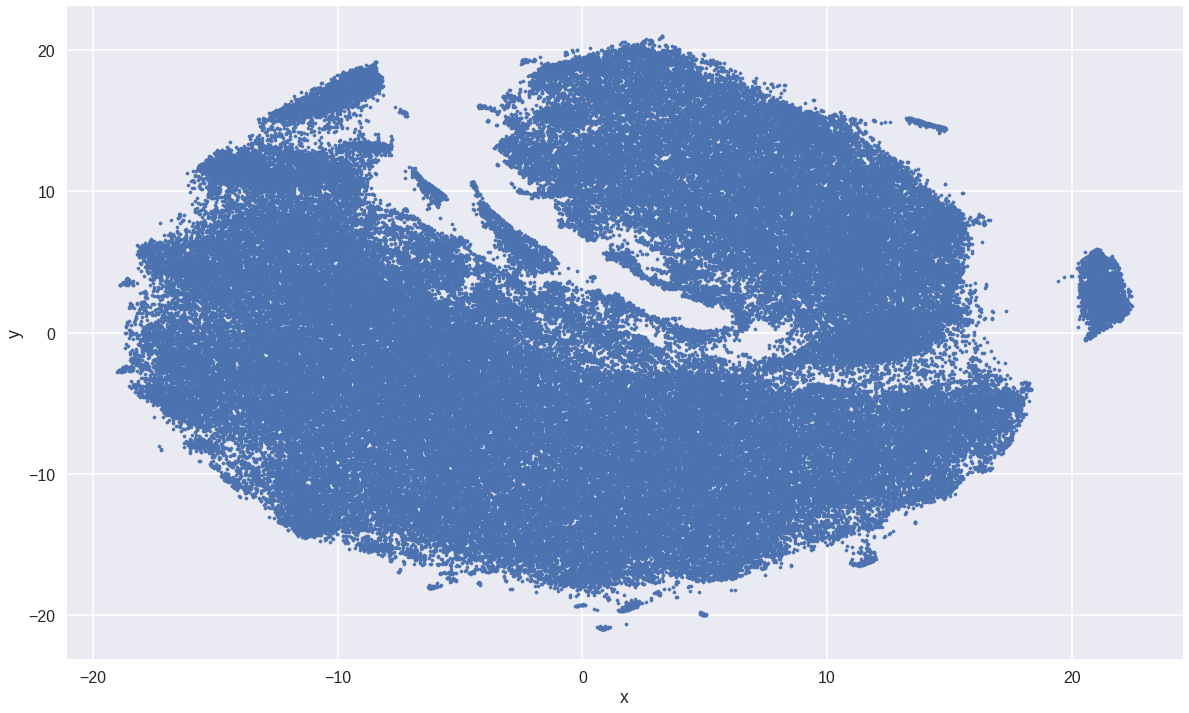

In [341]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [342]:
#thanks to https://github.com/YuriyGuts/thrones2vec/blob/master/Thrones2Vec.ipynb for the function
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

Let's plot some regions of the embedding. I didn't try to find any clusters of similar words because it isn't our task, but potentially something interesting could be found there.

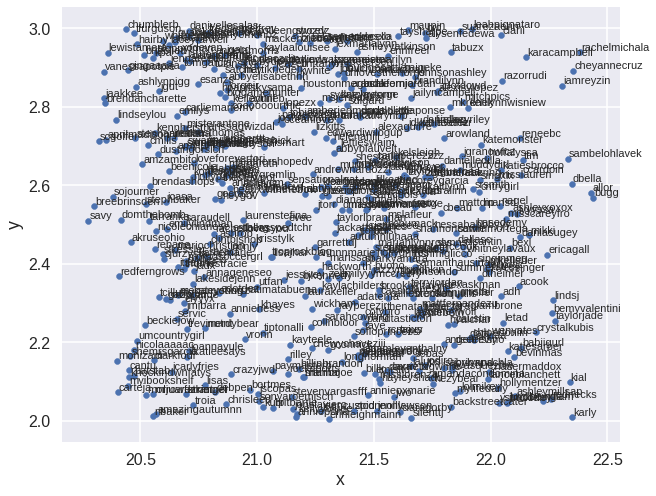

In [358]:
plot_region(x_bounds=(20.0, 23.0), y_bounds=(2.0, 3.0))

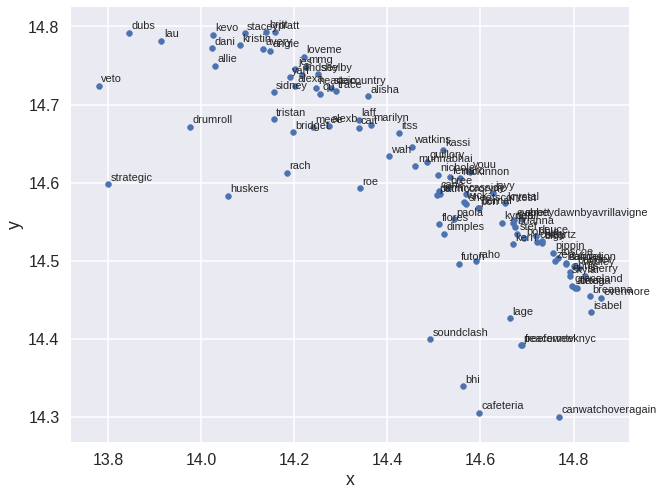

In [362]:
plot_region(x_bounds=(13.0, 15.0), y_bounds=(14.3, 14.8))

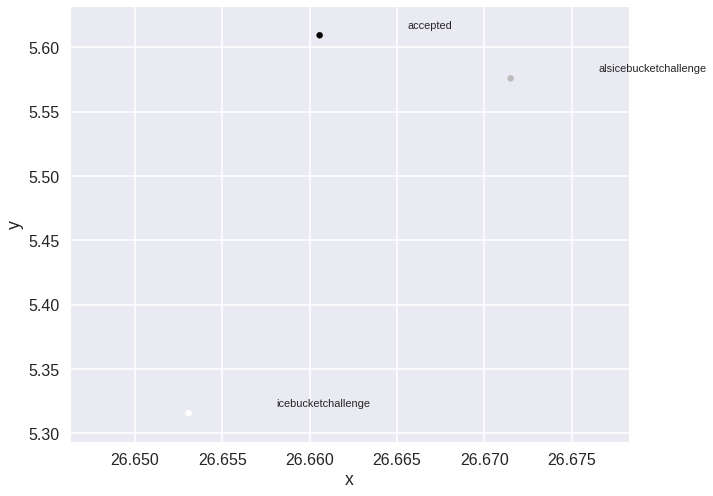

In [288]:
plot_region(x_bounds=(26.2, 27.2), y_bounds=(5.0, 7.0))

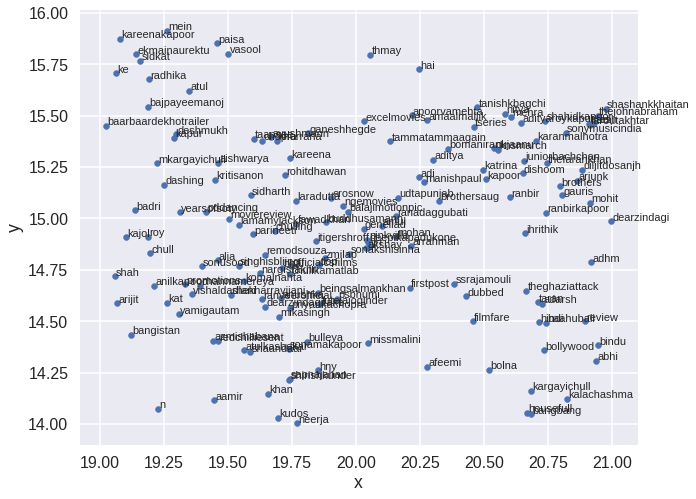

In [289]:
plot_region(x_bounds=(19.0, 21.0), y_bounds=(14.0, 16.0))

In [343]:
tweet2vec.most_similar('kanyewest')

2017-05-22 18:44:41,406 : INFO : precomputing L2-norms of word weight vectors


[(u'thomasrhett', 0.8875970840454102),
 (u'iggyazalea', 0.8843071460723877),
 (u'chancetherapper', 0.8820422291755676),
 (u'theweeknd', 0.8742468357086182),
 (u'ddlovato', 0.8657597303390503),
 (u'runawaywithme', 0.8624573945999146),
 (u'robinthicke', 0.8604978322982788),
 (u'edsheeran', 0.8583892583847046),
 (u'mariahcarey', 0.8570566773414612),
 (u'tydollasign', 0.8559160828590393)]

In [344]:
tweet2vec.most_similar('linkinpark')

[(u'heavylp', 0.8914578557014465),
 (u'mikeshinoda', 0.8900164365768433),
 (u'kiiara', 0.8815193176269531),
 (u'worldrecord', 0.8610801696777344),
 (u'chesterbe', 0.8595069646835327),
 (u'onemorelight', 0.8558931946754456),
 (u'afth', 0.8422032594680786),
 (u'musiclive', 0.8415356278419495),
 (u'laurenlaverne', 0.8415051102638245),
 (u'therkop', 0.8410972952842712)]

In [345]:
tweet2vec.most_similar('cumberbatch')

[(u'benedict', 0.9542884826660156),
 (u'girlcrush', 0.9375365972518921),
 (u'tweetsauce', 0.9365564584732056),
 (u'uproxx', 0.93464595079422),
 (u'byrne', 0.9345823526382446),
 (u'druyan', 0.9345079660415649),
 (u'marciaclark', 0.9336634874343872),
 (u'meryl', 0.9319806694984436),
 (u'kidman', 0.9316638708114624),
 (u'triggerstreet', 0.931405246257782)]

In [346]:
tweet2vec.most_similar('king')

[(u'assassin', 0.7998483180999756),
 (u'origin', 0.7826043367385864),
 (u'luther', 0.7801247835159302),
 (u'jr', 0.7578120231628418),
 (u'tupac', 0.7548874020576477),
 (u'mlkday', 0.7262634634971619),
 (u'martin', 0.7212724685668945),
 (u'beginnings', 0.7204842567443848),
 (u'og', 0.718938946723938),
 (u'pacsdjkingassassin', 0.718562662601471)]

In [347]:
tweet2vec.most_similar('twitter')

[(u'facebook', 0.7223414778709412),
 (u'account', 0.7146210074424744),
 (u'reddit', 0.7024297714233398),
 (u'takeasheet', 0.6983987092971802),
 (u'tumblr', 0.696393609046936),
 (u'cricketnation', 0.6958399415016174),
 (u'ama', 0.6893362998962402),
 (u'twittermusic', 0.6859310269355774),
 (u'afncosbytroops', 0.6857844591140747),
 (u'iheartpink', 0.6830990314483643)]

In [348]:
tweet2vec.most_similar('what')

[(u'whatever', 0.6737889051437378),
 (u'whats', 0.6661441326141357),
 (u'wtf', 0.6469865441322327),
 (u'differently', 0.63993901014328),
 (u'authoramish', 0.6364739537239075),
 (u'whatcha', 0.6291688680648804),
 (u'nickfradiani', 0.6242003440856934),
 (u'clarkbeckham', 0.6189123392105103),
 (u'alike', 0.6167223453521729),
 (u'alien', 0.616125226020813)]

In [376]:
tweet2vec.most_similar('donald')

[(u'donaldtrump', 0.9061661958694458),
 (u'trump', 0.8853811025619507),
 (u'clinton', 0.883206844329834),
 (u'berniesanders', 0.8801568746566772),
 (u'sterling', 0.8766869902610779),
 (u'pence', 0.8700660467147827),
 (u'hillary', 0.8624024391174316),
 (u'administration', 0.859580397605896),
 (u'claims', 0.8590174913406372),
 (u'mitt', 0.8570683002471924)]

Let's encode each word in the sentences with a vector

In [296]:
tweet2vec.wv['what']

array([  6.70101792e-02,   1.16556965e-01,   5.65127730e-02,
         1.91056997e-01,  -2.18316037e-02,   1.05414450e-01,
        -1.76081255e-01,  -3.08195084e-01,   1.22134037e-01,
         3.80238965e-02,  -2.12831512e-01,  -2.66053289e-01,
        -3.68501276e-01,  -1.38207346e-01,  -6.82209581e-02,
         2.87220925e-01,   1.61081269e-01,   2.79349685e-01,
        -1.29825413e-01,   7.85352886e-02,   2.20095396e-01,
        -1.81141481e-01,  -3.19783054e-02,  -3.00720155e-01,
        -2.91392207e-01,   1.35566786e-01,   1.65726885e-01,
         2.43230369e-02,   4.63770889e-02,  -8.87760520e-03,
        -5.79128005e-02,  -2.02988237e-01,  -6.17841892e-02,
        -2.29628637e-01,   2.14403607e-02,   2.21610412e-01,
         9.41891223e-02,  -3.27498512e-03,   1.11471929e-01,
        -1.35162100e-01,   6.99065998e-02,   4.77251830e-03,
        -1.26914412e-01,   1.71733573e-02,  -4.38598078e-03,
         5.49277104e-02,   9.75164250e-02,   8.83425623e-02,
         4.86195862e-01,

In [349]:
df['vectorized_text'] = df['tokenized_text'].apply(lambda row: [[tweet2vec.wv[word] for word in sentence] for sentence in row])

In [354]:
df.head()

,tags,text,tokenized_text,vectorized_text
0,"['boro', 'UTB']",Today we were in the Hospital visiting some ch...,"[[today, we, were, in, the, hospital, visiting...","[[[0.121696, 0.221147, -0.0558842, 0.0840078, ..."
1,['coyr'],I'm very proud to be part of Standard de Liege...,"[[i, m, very, proud, to, be, part, of, standar...","[[[0.122679, 0.218179, -0.10559, 0.0762177, -0..."
2,['gracias'],#gracias @ManUtd Family !,"[[gracias, manutd, family]]","[[[0.0884576, 0.219514, -0.016693, -0.0731909,..."
3,"['nature', 'meditation']",Enjoying a moment of silence and calm at Dunha...,"[[enjoying, a, moment, of, silence, and, calm,...","[[[0.139412, 0.248114, -0.179658, -0.00424204,..."
4,['mufc'],No matter what happens. \nThe only way I know ...,"[[no, matter, what, happens], [the, only, way,...","[[[-0.201636, 0.186126, 0.28564, -0.0426051, -..."


In [1]:
import pickle
with open('/mnt/bulky1/achashchin/twitter/600d/twitter_df.pickle', 'wb') as f:
    pickle.dump(df, f)